# anatomix (ICLR'25) tutorial

#### [Paper link](https://arxiv.org/abs/2411.02372) | [GitHub link](https://github.com/neel-dey/anatomix)

In this tutorial, we'll cover how to:
1. Extract 3D features that are approximately stable to modality and appearance changes.
2. Use anatomix features for 3D multimodality registration and **reproduce** our Learn2Reg MRCT results.

If you want to *finetune* the pretrained model for your own datasets or tasks, check out [this tutorial](https://colab.research.google.com/drive/1WBslSRLgAAMq6o5YFif1y0kaW9Ac15XK?usp=sharing) instead.

# 1. 3D feature extraction using anatomix

In [1]:
!hostname

gl1522.arc-ts.umich.edu


In [2]:
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from glob import glob
import os
from tqdm import tqdm
import SimpleITK as sitk
import torchio as tio


In [3]:
from anatomix.model.network import Unet

In [4]:
ROOT = "/home/minsukc/MRI2CT/"
# DATA_DIR_ROOT = "/scratch/jjparkcv_root/jjparkcv98/minsukc/"
DATA_DIR = os.path.join(ROOT,"data")

### Load pretrained model and data

In [5]:
# Instantiate model and load pretrained weights
model = Unet(
    dimension=3,  # Only 3D supported for now
    input_nc=1,  # number of input channels
    output_nc=16,  # number of output channels
    num_downs=4,  # number of downsampling layers
    ngf=16,  # channel multiplier
).cuda()

model.load_state_dict(
    torch.load(os.path.join(ROOT, "anatomix/model-weights/anatomix.pth")),
    strict=True,
)
model.eval()
print("Model loaded!")

Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Model loaded!


In [6]:
# target = "1ABB062_2x2x2_resampled"
# target = "1HNC073_2x2x2_resampled"
# target = "1ABA103_2x2x2_resampled"
target = "1ABA103_3x3x3_resampled"
# target = "1THB211_3x3x3_resampled"
target_dir = os.path.join(DATA_DIR, target)
mr_img = os.path.join(target_dir, "mr_resampled.nii.gz")
ct_img = os.path.join(target_dir, "ct_resampled.nii.gz")
mask = os.path.join(target_dir, "mask_resampled.nii.gz")
ct_seg = os.path.join(target_dir, "ct_seg.nii.gz")
mr_seg = os.path.join(target_dir, "mr_seg.nii.gz")

In [7]:
def minmax(arr, minclip=None, maxclip=None):
    if not (minclip is None) & (maxclip is None):
        arr = np.clip(arr, minclip, maxclip)
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    return arr

def pad_to_multiple_np(arr, multiple=16):
    D, H, W = arr.shape
    pad_D = (multiple - D % multiple) % multiple
    pad_H = (multiple - H % multiple) % multiple
    pad_W = (multiple - W % multiple) % multiple
    return np.pad(arr,
                  ((0, pad_D), (0, pad_H), (0, pad_W)),
                  mode='constant'), (pad_D, pad_H, pad_W)

# Load raw data
mr_raw = nib.load(mr_img).get_fdata()
mri = minmax(mr_raw)
ct_raw = nib.load(ct_img).get_fdata()
ct = minmax(ct_raw, minclip=-450, maxclip=450)
mask_raw = nib.load(mask).get_fdata()
ct_seg_raw = nib.load(ct_seg).get_fdata()
mr_seg_raw = nib.load(mr_seg).get_fdata()

# Pad all
mr_pad, pad_vals = pad_to_multiple_np(mri, 16)
ct_pad, _        = pad_to_multiple_np(ct, 16)
mask_pad, _      = pad_to_multiple_np(mask_raw, 16)
ct_seg_pad, _ = pad_to_multiple_np(ct_seg_raw, 16)
mr_seg_pad, _ = pad_to_multiple_np(mr_seg_raw, 16)

# Save padded versions (so convex_adam sees padded shapes)
mr_padded_path   = os.path.join(target_dir, "mr_padded.nii.gz")
ct_padded_path   = os.path.join(target_dir, "ct_padded.nii.gz")
mask_padded_path = os.path.join(target_dir, "mask_padded.nii.gz")
ct_seg_padded_path = os.path.join(target_dir, "ct_seg_padded.nii.gz")
mr_seg_padded_path = os.path.join(target_dir, "mr_seg_padded.nii.gz")

nib.save(nib.Nifti1Image(mr_pad, np.eye(4)), mr_padded_path)
nib.save(nib.Nifti1Image(ct_pad, np.eye(4)), ct_padded_path)
nib.save(nib.Nifti1Image(mask_pad, np.eye(4)), mask_padded_path)
nib.save(nib.Nifti1Image(ct_seg_pad, np.eye(4)), ct_seg_padded_path)
nib.save(nib.Nifti1Image(mr_seg_pad, np.eye(4)), mr_seg_padded_path)

print("Loaded raw shapes:", mr_raw.shape, ct_raw.shape, mask_raw.shape, ct_seg_raw.shape, mr_seg_raw.shape)
print("Padded shapes:", mr_pad.shape, ct_pad.shape, mask_pad.shape, ct_seg_pad.shape, mr_seg_pad.shape)
print("Padding applied (D,H,W):", pad_vals)
print("Saved padded files at:", mr_padded_path)

Loaded raw shapes: (153, 131, 85) (153, 131, 85) (153, 131, 85) (153, 131, 85) (153, 131, 85)
Padded shapes: (160, 144, 96) (160, 144, 96) (160, 144, 96) (160, 144, 96) (160, 144, 96)
Padding applied (D,H,W): (7, 13, 11)
Saved padded files at: /home/minsukc/MRI2CT/data/1ABA103_3x3x3_resampled/mr_padded.nii.gz


In [8]:
# sliceidx = 60

# plt.figure(figsize=(10, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(np.rot90(mr[:, :, sliceidx]), cmap="gray")  # Axial view
# plt.title("MRI")
# plt.axis("off")

# plt.subplot(1, 2, 2)
# plt.imshow(np.rot90(ct[:, :, sliceidx]), cmap="gray")  # Axial view
# plt.title("CT")
# plt.axis("off")

# plt.tight_layout()
# plt.show()

### Extract invariant features and visualize outputs

In [9]:
import torch.nn.functional as F

# def pad_to_multiple(tensor, multiple=16):
#     """Pad tensor [B, C, D, H, W] so each spatial dim is a multiple of `multiple`."""
#     _, _, D, H, W = tensor.shape
#     pad_D = (multiple - D % multiple) % multiple
#     pad_H = (multiple - H % multiple) % multiple
#     pad_W = (multiple - W % multiple) % multiple
#     pad = (0, pad_W, 0, pad_H, 0, pad_D)
#     tensor_padded = F.pad(tensor, pad, mode="constant", value=0)
#     pad_width = ((0, pad_D), (0, pad_H), (0, pad_W))
#     return tensor_padded, pad_width


# def unpad_tensor(tensor, pad_width):
#     """Crop a padded tensor [B, C, D, H, W] back to its original size."""
#     d_pad, h_pad, w_pad = pad_width
#     d_end = None if d_pad[1] == 0 else -d_pad[1]
#     h_end = None if h_pad[1] == 0 else -h_pad[1]
#     w_end = None if w_pad[1] == 0 else -w_pad[1]
#     return tensor[..., 0:d_end, 0:h_end, 0:w_end]


# Extract 3D features:
with torch.no_grad():
    mri_inp = torch.from_numpy(mr_pad[None, None]).float().cuda()
    # mri_inp, mri_pad = pad_to_multiple(mri_inp, multiple=16)
    mri_feats = model(mri_inp)
    # mri_feats = unpad_tensor(mri_feats, mri_pad)

    ct_inp = torch.from_numpy(ct_pad[None, None]).float().cuda()
    # ct_inp, ct_pad = pad_to_multiple(ct_inp, multiple=16)
    ct_feats = model(ct_inp)
    # ct_feats = unpad_tensor(ct_feats, ct_pad)


# The pretrained network produces outputs with 16 channels:
print(f"Output MRI features shape: {mri_feats.shape}")
print(f"Output CT features shape: {ct_feats.shape}")

Output MRI features shape: torch.Size([1, 16, 160, 144, 96])
Output CT features shape: torch.Size([1, 16, 160, 144, 96])


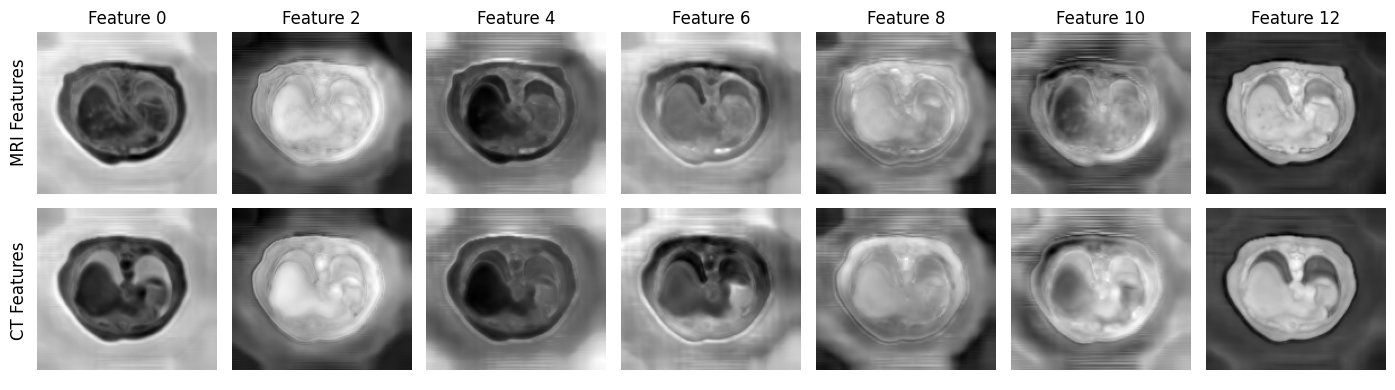

In [10]:
sliceidx = 60

plt.figure(figsize=(14, 4))

# Add row titles
plt.text(-0.02, 0.75, "MRI Features", fontsize=12, va="center", rotation=90)
plt.text(-0.02, 0.25, "CT Features", fontsize=12, va="center", rotation=90)
plt.axis("off")

# Visualize a subset of all channels
# MRI outputs
for i in range(7):
    plt.subplot(2, 7, i + 1)
    plt.imshow(
        np.rot90(mri_feats[0, i * 2, :, :, sliceidx].cpu().numpy()),
        cmap="gray",
    )
    plt.axis("off")
    plt.title(f"Feature {i * 2}")

# CT outputs
for i in range(7):
    plt.subplot(2, 7, 7 + (i + 1))
    plt.imshow(
        np.rot90(ct_feats[0, i * 2, :, :, sliceidx].cpu().numpy()),
        cmap="gray",
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

# 2. Multimodality registration using anatomix

We're going to do intrasubject registration on Learn2RegMRCT by registering the MRIs to the CTs.

In [11]:
# Load registration module
# We use a heavily modified fork of the convexadam repository as our solver here
from anatomix.registration import convex_adam

/home/minsukc/micromamba/envs/mri2ct/lib/python3.10/site-packages/monai/utils/module.py:399: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module


**NOTE FOR OTHER DATASETS**: The convexadam solver requires careful tuning of registration hyperparameters. The settings here were found via grid search on Subject 1 (index 0) of this dataset (our validation subject). It is likely that your own dataset will require other convexadam hyperparameters.

### Grid search for convexadam hyperparameters

In [12]:
# ABDOMEN_MAJOR_MAP = {
#     1: "Spleen",
#     2: "Kidney_Right",
#     3: "Kidney_Left",
#     5: "Liver"
# }

# def compute_dice_abdomen(gt_path, pred_path):
#     try:
#         gt = nib.load(gt_path).get_fdata().astype(np.uint16)
#         pred = nib.load(pred_path).get_fdata().astype(np.uint16)
#     except Exception as e:
#         print(f"   Error loading: {e}")
#         return 0.0

#     gt_present = np.unique(gt)
#     pred_present = np.unique(pred)
#     scores = []

#     print(f"\n   {'Organ':<15} | {'ID':<3} | {'Dice'}")
#     print(f"   {'-'*30}")

#     for organ_id, organ_name in ABDOMEN_MAJOR_MAP.items():
#         # Check if organ exists in the images
#         if organ_id not in gt_present or organ_id not in pred_present:
#             print(f"   {organ_name:<15} | {organ_id:<3} | -- (Missing)")
#             continue

#         # Compute Dice
#         y_true = (gt == organ_id)
#         y_pred = (pred == organ_id)
        
#         intersection = np.sum(y_true * y_pred)
#         total = np.sum(y_true) + np.sum(y_pred)
        
#         dice = (2.0 * intersection) / (total + 1e-6)
#         scores.append(dice)
#         print(f"   {organ_name:<15} | {organ_id:<3} | {dice:.4f}")

#     if not scores:
#         return 0.0

#     avg = np.mean(scores)
#     print(f"   {'-'*30}")
#     print(f"   ✅ Major 4 Avg:  {avg:.4f}")
#     return avg

In [13]:
# TUNE_DIR = os.path.join(DATA_DIR, "tune_results")
# os.makedirs(TUNE_DIR, exist_ok=True)

# # Tuning Ranges
# lambda_candidates = [0.5, 0.75, 1.0] 
# grid_sp_candidates = [2, 3]          
# smooth_candidates = [0, 1]           

# results = []

# for lam in lambda_candidates:
#     for grid in grid_sp_candidates:
#         for sm in smooth_candidates:
#             expname = f"lam{lam}_grid{grid}_sm{sm}"
#             print(f"\n🔹 Running: {expname}")

#             expdir = os.path.join(TUNE_DIR, expname)
#             os.makedirs(expdir, exist_ok=True)

#             # Run Registration
#             convex_adam(
#                 ckpt_path=os.path.join(ROOT, "anatomix/model-weights/anatomix.pth"),
#                 expname=expname,
#                 result_path=expdir,
#                 lambda_weight=lam,
#                 grid_sp=grid,
#                 disp_hw=1,
#                 selected_niter=80,
#                 selected_smooth=sm,
#                 grid_sp_adam=grid,
#                 ic=True,
#                 use_mask=True,
#                 warp_seg=True,
#                 fixed_image=ct_padded_path,
#                 fixed_mask=mask_padded_path,
#                 fixed_seg=ct_seg_padded_path,
#                 fixed_minclip=-450,
#                 fixed_maxclip=450,
#                 moving_image=mr_padded_path,
#                 moving_mask=mask_padded_path,
#                 moving_seg=mr_seg_padded_path,
#             )

#             # Evaluate on Big 4
#             pred_candidates = sorted(glob(os.path.join(expdir, "labels_moved_*.nii.gz")))
            
#             if len(pred_candidates) > 0:
#                 dice = compute_dice_abdomen(ct_seg_padded_path, pred_candidates[0])
#             else:
#                 dice = 0.0

#             results.append((lam, grid, sm, dice))

# # Summarize
# results = sorted(results, key=lambda x: x[-1], reverse=True)
# print("\nGrid Search Completed!")
# print("Top 3 Configurations:")
# for lam, grid, sm, dice in results[:3]:
#     print(f"Dice={dice:.4f} | λ={lam}, grid={grid}, smooth={sm}")

# best = results[0]
# print(f"\n🏆 Winner: λ={best[0]}, grid={best[1]}, smooth={best[2]}")

In [14]:
# import nibabel as nib
# import numpy as np

# fixed_seg = nib.load(ct_seg_padded_path).get_fdata()
# moved_seg = nib.load(pred_candidates[0]).get_fdata()

# print("Fixed seg shape:", fixed_seg.shape)
# print("Moved seg shape:", moved_seg.shape)

# print("Fixed unique labels:", np.unique(fixed_seg)[:20])
# print("Moved unique labels:", np.unique(moved_seg)[:20])

In [15]:
# import matplotlib.pyplot as plt
# import numpy as np
# import nibabel as nib
# from glob import glob

# # --- Load images ---
# fixed_ct = nib.load(ct_padded_path).get_fdata()
# moving_mr = nib.load(mr_padded_path).get_fdata()
# moved_mr = nib.load(sorted(glob(os.path.join(expdir, "moved_mr*.nii.gz")))[0]).get_fdata()

# # --- Normalize for display ---
# def norm(x, vmin=None, vmax=None):
#     if vmin is not None and vmax is not None:
#         x = np.clip(x, vmin, vmax)
#     return (x - x.min()) / (x.max() - x.min() + 1e-8)

# ct_disp = norm(fixed_ct, -450, 450)
# mr_disp = norm(moving_mr)
# moved_disp = norm(moved_mr)

# # --- Load segmentations ---
# fixed_seg = nib.load(ct_seg_padded_path).get_fdata()
# moved_seg = nib.load(sorted(glob(os.path.join(expdir, "labels_moved_*.nii.gz")))[0]).get_fdata()

# # --- Slice selection ---
# # sliceidx = fixed_ct.shape[2] // 2
# sliceidx = 30

# # --- Plot ---
# plt.figure(figsize=(22, 10))

# # 1️⃣ Fixed CT
# plt.subplot(2, 3, 1)
# plt.imshow(np.rot90(ct_disp[:, :, sliceidx]), cmap="gray")
# plt.title("Fixed CT")
# plt.axis("off")

# # 2️⃣ Moving MRI (before registration)
# plt.subplot(2, 3, 2)
# plt.imshow(np.rot90(mr_disp[:, :, sliceidx]), cmap="gray")
# plt.title("Moving MRI (Before)")
# plt.axis("off")

# # 3️⃣ Moved MRI (after registration)
# plt.subplot(2, 3, 3)
# plt.imshow(np.rot90(moved_disp[:, :, sliceidx]), cmap="gray")
# plt.title("Moved MRI (After Registration)")
# plt.axis("off")

# # 4️⃣ Fixed CT segmentation
# plt.subplot(2, 3, 4)
# plt.imshow(np.rot90(fixed_seg[:, :, sliceidx]), cmap="tab20")
# plt.title("Fixed CT Segmentation")
# plt.axis("off")

# # 5️⃣ Warped MR segmentation
# plt.subplot(2, 3, 5)
# plt.imshow(np.rot90(moved_seg[:, :, sliceidx]), cmap="tab20")
# plt.title("Warped MR Segmentation")
# plt.axis("off")

# # 6️⃣ Overlay for alignment check
# plt.subplot(2, 3, 6)
# plt.imshow(np.rot90(ct_disp[:, :, sliceidx]), cmap="gray")
# plt.imshow(np.rot90(moved_seg[:, :, sliceidx]), cmap="cool", alpha=0.4)
# plt.title("Overlay: CT + Warped MR Seg")
# plt.axis("off")

# plt.tight_layout()
# plt.show()

In [16]:
# plt.figure(figsize=(6,6))
# plt.imshow(np.rot90(mr_seg_raw[:, :, sliceidx]), cmap="tab20")
# plt.title("Raw MRI Segmentation Output")
# plt.axis("off")
# plt.show()

### Compute registrations

In [17]:
# Create scratch output directory
# os.makedirs("./demo", exist_ok=True)

OUTPUT_DIR = os.path.join(target_dir, "registration_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Loop over all subjects and save outputs to disk:
# for i in range(8):
convex_adam(
    ckpt_path=os.path.join(ROOT, "./anatomix/model-weights/anatomix.pth"),
    expname="demo",
    result_path=OUTPUT_DIR,
    lambda_weight=0.75,
    grid_sp=2,
    disp_hw=1,
    selected_niter=80,
    selected_smooth=0,
    grid_sp_adam=2,
    ic=True,
    use_mask=True,
    warp_seg=True,
    # warp_seg=False,
    fixed_image=ct_padded_path,
    fixed_mask=mask_padded_path,
    fixed_seg=ct_seg_padded_path,
    fixed_minclip=-450,
    fixed_maxclip=450,
    moving_image=mr_padded_path,
    moving_mask=mask_padded_path,
    moving_seg=mr_seg_padded_path,
)

Loading model
Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Running network on input images
case time:  0.6438424587249756
Dice: 0.12084356019523866


### Compute test set results

In [18]:
predictions = sorted(glob("./demo/labels_moved*.nii.gz"))
gts = sorted(glob("./AbdomenMRCT/labelsTr/*_0001.nii.gz"))[:8]

assert len(predictions) == len(gts)

# Compute test set results:
dices = np.zeros(len(predictions))

for i in range(len(predictions)):
    pred = nib.load(predictions[i]).get_fdata()
    gt = nib.load(gts[i]).get_fdata()
    dices[i] = f1_score(
        y_true=gt.flatten().astype(np.uint8),
        y_pred=pred.flatten().astype(np.uint8),
        average="macro",
        labels=np.unique(gt.flatten())[1:],
    )

# In our paper, we tuned the hyperparameters on subject 1 and tested on the
# remaining seven
print(f"Test set median Dice: {np.median(dices[1:])}")

Test set median Dice: nan


### Visualize registration results

In [19]:
def load_nifti_for_viz(fpath):
    nii = nib.load(fpath)
    arr = nii.get_fdata().squeeze()
    return arr

def unpad_np(arr, pad_vals):
    pad_D, pad_H, pad_W = pad_vals
    D_end = None if pad_D == 0 else -pad_D
    H_end = None if pad_H == 0 else -pad_H
    W_end = None if pad_W == 0 else -pad_W
    return arr[:D_end, :H_end, :W_end]

# Load input fixed and moving volumes
fixed_ct = load_nifti_for_viz(ct_img)
fixed_ct = minmax(fixed_ct, minclip=-450, maxclip=450)
moving_mr = load_nifti_for_viz(mr_img)
moving_mr = minmax(moving_mr)

# Load computed moved mri and displacement field
moved_imgs = sorted(glob(os.path.join(OUTPUT_DIR, "moved_mr*.nii.gz")))
moved_mr_pad = nib.load(moved_imgs[0]).get_fdata()
moved_mr = unpad_np(moved_mr_pad, pad_vals)
nib.save(nib.Nifti1Image(moved_mr, np.eye(4)),
         os.path.join(OUTPUT_DIR, "moved_mr_unpadded.nii.gz"))

# Displacement field's a (x, y, z, 3) array, we use its norm for viz
moved_disp = sorted(glob(os.path.join(OUTPUT_DIR, "disp_mr*.nii.gz")))
disp_pad = nib.load(moved_disp[0]).get_fdata()        # (D,H,W,3)
mag_pad = np.linalg.norm(disp_pad, axis=-1)       # (D,H,W)
mag_unpad = unpad_np(mag_pad, pad_vals)
mag_norm = minmax(mag_unpad)
nib.save(nib.Nifti1Image(mag_norm, np.eye(4)),
         os.path.join(OUTPUT_DIR, "disp_magnitude_unpadded.nii.gz"))

# After registration with warp_seg=True
moved_seg_files = sorted(glob(os.path.join(OUTPUT_DIR, "labels_moved_*.nii.gz")))
moved_seg_pad = nib.load(moved_seg_files[0]).get_fdata()
moved_seg = unpad_np(moved_seg_pad, pad_vals)
nib.save(nib.Nifti1Image(moved_seg, np.eye(4)), os.path.join(OUTPUT_DIR, "labels_moved_unpadded.nii.gz"))

In [20]:
print("=== Shape Verification ===")

# Original shapes
print("Original MR shape:", mr_raw.shape)

# Padded shapes
print("Padded MR shape:", mr_pad.shape)

# After unpadding moved MRI
print("Moved MRI (unpadded) shape:", moved_mr.shape)

# After unpadding moved MRI
print("Moved Seg (unpadded) shape:", moved_seg.shape)

# Compare with originals
print("MR matches original?:", moved_mr.shape == mr_raw.shape)
print("Disp matches original?:", mag_unpad.shape == mr_raw.shape)


=== Shape Verification ===
Original MR shape: (153, 131, 85)
Padded MR shape: (160, 144, 96)
Moved MRI (unpadded) shape: (153, 131, 85)
Moved Seg (unpadded) shape: (153, 131, 85)
MR matches original?: True
Disp matches original?: True


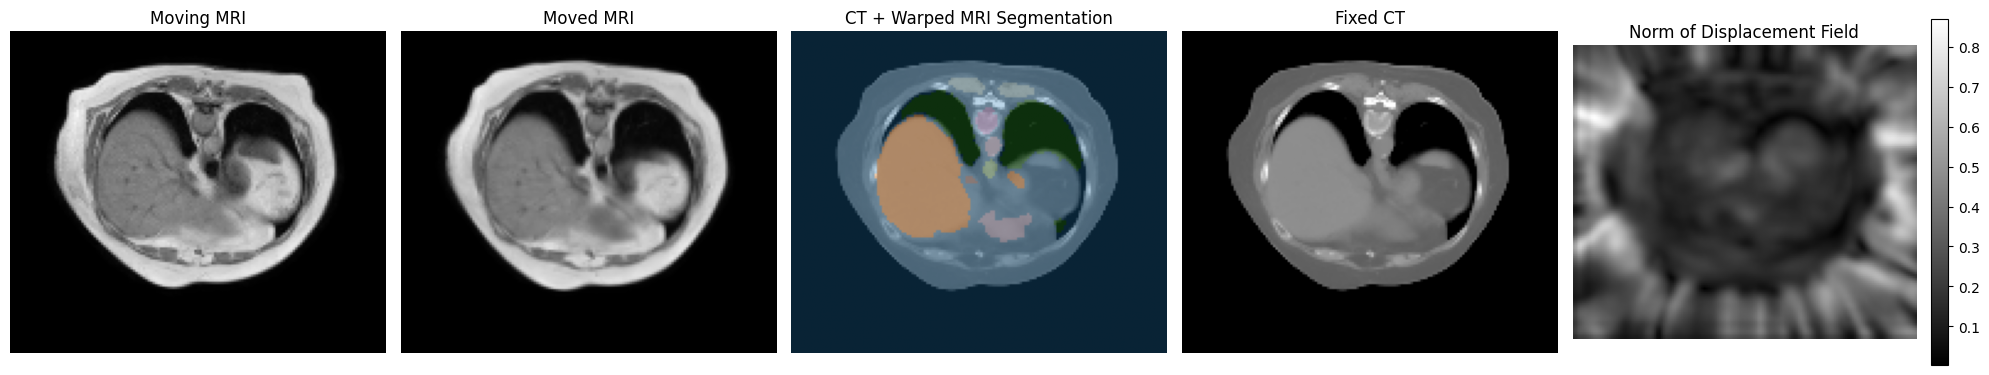

In [21]:
sliceidx = 60

plt.figure(figsize=(20, 10))

# Moving MRI
plt.subplot(1, 5, 1)
plt.imshow(np.rot90(moving_mr[:, :, sliceidx]), cmap="gray",vmin=0,vmax=1)
plt.title("Moving MRI")
plt.axis("off")

# Moved MRI
plt.subplot(1, 5, 2)
plt.imshow(np.rot90(moved_mr[:, :, sliceidx]), cmap="gray",vmin=0,vmax=1)
plt.title("Moved MRI")
plt.axis("off")

# Moved Seg
plt.subplot(1, 5, 3)
plt.imshow(np.rot90(fixed_ct[:,:,sliceidx]), cmap='gray')
plt.imshow(np.rot90(moved_seg[:,:,sliceidx]), cmap='tab20', alpha=0.3)
plt.title("CT + Warped MRI Segmentation")
plt.axis("off")

# Fixed CT
plt.subplot(1, 5, 4)
plt.imshow(np.rot90(fixed_ct[:, :, sliceidx]), cmap="gray")
plt.title("Fixed CT")
plt.axis("off")

# Displacement norm + colorbar
ax = plt.subplot(1, 5, 5)
im = ax.imshow(np.rot90(mag_norm[:, :, sliceidx]), cmap="gray")
ax.set_title("Norm of Displacement Field")
ax.axis("off")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


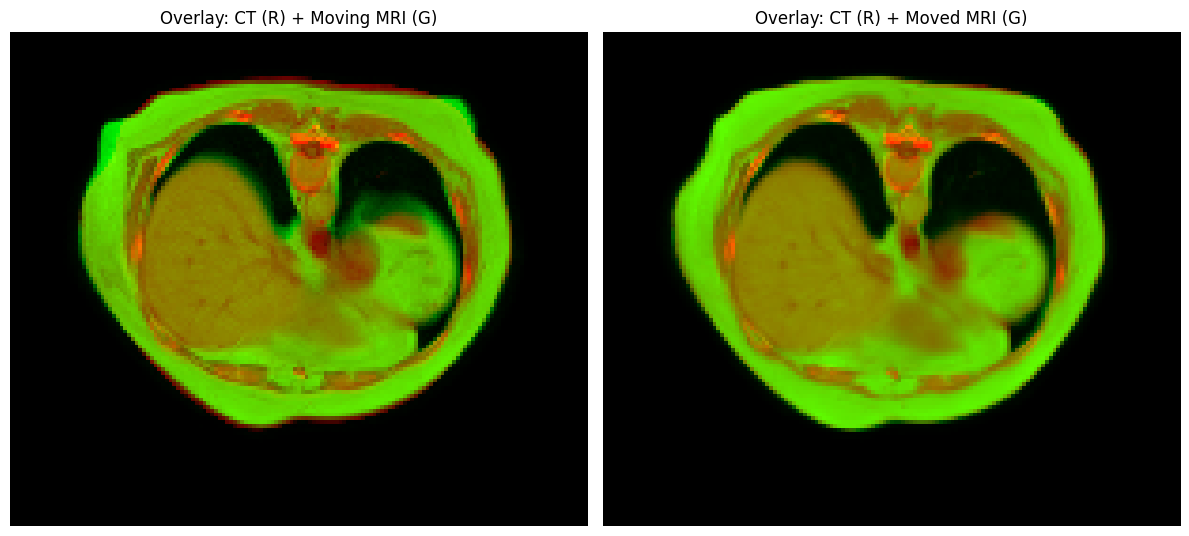

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def make_rgb_overlay(ct_slice, mr_slice):
    """Build RGB overlay with:
       R = CT
       G = MRI
       B = 0
    """
    ct_norm = (ct_slice - ct_slice.min()) / (ct_slice.max() - ct_slice.min() + 1e-8)
    mr_norm = (mr_slice - mr_slice.min()) / (mr_slice.max() - mr_slice.min() + 1e-8)

    rgb = np.zeros((*ct_norm.shape, 3), dtype=np.float32)
    rgb[..., 0] = ct_norm        # Red
    rgb[..., 1] = mr_norm        # Green
    rgb[..., 2] = 0              # Blue always zero

    return rgb

# pick a slice
sliceidx = 60

# extract axial slices
ct_sl = np.rot90(fixed_ct[:, :, sliceidx])
mr_sl = np.rot90(moving_mr[:, :, sliceidx])
moved_sl = np.rot90(moved_mr[:, :, sliceidx])

# make overlays
rgb_before = make_rgb_overlay(ct_sl, mr_sl)
rgb_after  = make_rgb_overlay(ct_sl, moved_sl)

# display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(rgb_before)
plt.title("Overlay: CT (R) + Moving MRI (G)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rgb_after)
plt.title("Overlay: CT (R) + Moved MRI (G)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [23]:
DELETE_TEMP_PADDED = True
if DELETE_TEMP_PADDED:
    for f in [mr_padded_path, ct_padded_path, mask_padded_path,
              mr_seg_padded_path, ct_seg_padded_path]:
        if os.path.exists(f):
            os.remove(f)
    for f in moved_imgs + moved_disp + moved_seg_files:
        os.remove(f)
    print("Temporary padded files deleted.")

Temporary padded files deleted.


In [24]:
print(mr_padded_path, ct_padded_path, mask_padded_path,
              mr_seg_padded_path, ct_seg_padded_path)

/home/minsukc/MRI2CT/data/1ABA103_3x3x3_resampled/mr_padded.nii.gz /home/minsukc/MRI2CT/data/1ABA103_3x3x3_resampled/ct_padded.nii.gz /home/minsukc/MRI2CT/data/1ABA103_3x3x3_resampled/mask_padded.nii.gz /home/minsukc/MRI2CT/data/1ABA103_3x3x3_resampled/mr_seg_padded.nii.gz /home/minsukc/MRI2CT/data/1ABA103_3x3x3_resampled/ct_seg_padded.nii.gz
